In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
%matplotlib inline
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import scipy.stats as stats
import statsmodels as sm

# Data Load In 

In [2]:
import Scripts_SigNonSig
reload(Scripts_SigNonSig)
from Scripts_SigNonSig import * 
import Scripts_Hierarchical_Boot
reload(Scripts_Hierarchical_Boot)
from Scripts_Hierarchical_Boot import * 

In [3]:
out = get_data_for_sig_nonsig_analyses()

/home/bishop/cgagne/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
Scripts_SigNonSig.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  region_data_single_row['Accuracy.50'] = np.mean(region_data['Accuracy.50'])
Scripts_SigNonSig.py:157: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df_50_sig = df_50_sig.sort('PID') ## careful with the soring #
Scripts_SigNonSig.py:165: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df_50_nonsig = df_50_nonsig.sort('PID') ## Careful with the sorting ##


In [4]:
#df_50_nonsig = out['df_50_nonsig']
#df_50_sig = out['df_50_sig']

df_50_nonsig = out['data_average_within_region_nonsig']
df_50_nonsig['Accuracy.50'] = df_50_nonsig['Accuracy.50'].astype('float')
df_50_sig = out['data_average_within_region_sig']
df_50_sig['Accuracy.50'] = df_50_sig['Accuracy.50'].astype('float')

In [5]:
#

# Boot-strap 

In [6]:
num_boots = 500
#accs_boot = np.empty((num_boots,len(df_50_sig)))

#prob_less_than
meann = np.array([])

mediann = np.array([])

prob_less_than_62 = np.array([])

sig_thresh1 = np.array([])
sig_thresh2 = np.array([])

prob_less_than_thresh1 = np.array([])
prob_less_than_thresh2 = np.array([])


x = np.linspace(0,1,100) # what range for cdf # 

epcdf_store_non = np.empty((num_boots,len(x)))
epcdf_store_sig = np.empty((num_boots,len(x)))


eppdf_store_non= np.empty((num_boots,len(x)))
eppdf_store_sig= np.empty((num_boots,len(x)))

for boot in range(num_boots):
                           
    # NON SIGS 
    studies_boot = np.random.choice(df_50_nonsig['PID'].unique(),len(df_50_nonsig['PID'].unique()),replace=True)
    study_accs_boot = np.array([])
    maxes = []
    for pid in studies_boot:
        # sample same number of observations within a pid
         study_acc_b_single = np.random.choice(df_50_nonsig.loc[df_50_nonsig['PID']==pid,'Accuracy.50'],size=len(df_50_nonsig.loc[df_50_nonsig['PID']==pid,'Accuracy.50']),replace=True)
         study_accs_boot= np.append(study_accs_boot,study_acc_b_single)
         maxes.append(np.max(study_acc_b_single))
    
    # store empirical distribution function
    ecdf = sm.distributions.empirical_distribution.ECDF(study_accs_boot)
    epcdf_store_non[boot,:]=ecdf(x)
    
    # store pdf
    kd = kde_scipy(study_accs_boot,x,bw_method='scott')
    eppdf_store_non[boot,:]=kd
    
    maxes = np.array(maxes)
    sig_thresh2_b = maxes.mean()
    sig_thresh2 = np.append(sig_thresh2,sig_thresh2_b)
    
    sig_thresh1_b = np.percentile(study_accs_boot,95)
    sig_thresh1 = np.append(sig_thresh1,sig_thresh1_b)
    
    # SIGS 
    studies_boot = np.random.choice(df_50_sig['PID'].unique(),len(df_50_sig['PID'].unique()),replace=True)
    study_accs_boot = np.array([])
    for pid in studies_boot:
        # sample same number of observations within a pid
         study_accs_boot= np.append(study_accs_boot,np.random.choice(df_50_sig.loc[df_50_sig['PID']==pid,'Accuracy.50'],size=len(df_50_sig.loc[df_50_sig['PID']==pid,'Accuracy.50']),replace=True))
    
    
    # store empirical distribution function
    ecdf = sm.distributions.empirical_distribution.ECDF(study_accs_boot)
    epcdf_store_sig[boot,:]=ecdf(x)
    
    # store pdf
    kd = kde_scipy(study_accs_boot,x,bw_method='scott')
    eppdf_store_sig[boot,:]=kd
    
    meann = np.append(meann,np.mean(study_accs_boot))
    mediann = np.append(mediann,np.median(study_accs_boot))
    
    prob_less_than_62 = np.append(prob_less_than_62,np.sum(study_accs_boot<.62)/float(len(study_accs_boot)))
    prob_less_than_thresh1 = np.append(prob_less_than_thresh1,np.sum(study_accs_boot<sig_thresh1_b)/float(len(study_accs_boot)))
    prob_less_than_thresh2 = np.append(prob_less_than_thresh2,np.sum(study_accs_boot<sig_thresh2_b)/float(len(study_accs_boot)))
    

In [7]:

np.savez('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_average_within_ROI',epcdf_store_non=epcdf_store_non,
          epcdf_store_si=epcdf_store_sig,
           eppdf_store_non= eppdf_store_non,
           eppdf_store_sig= eppdf_store_sig,
          meann= meann,
         mediann = mediann,
         prob_less_than_62 =prob_less_than_62,
         sig_thresh1=sig_thresh1,
         sig_thresh2=sig_thresh2)

In [8]:
print('prob less than 62')
print(np.percentile(prob_less_than_62,95))
print(np.mean(prob_less_than_62))
print(np.percentile(prob_less_than_62,5))


print('mean')
print(np.percentile(meann,95))
print(np.mean(meann))
print(np.percentile(meann,5))

print('median')
print(np.percentile(mediann,95))
print(np.mean(mediann))
print(np.percentile(mediann,5))

print('thresh 1')
print(np.percentile(sig_thresh1,95))
print(np.mean(sig_thresh1))
print(np.percentile(sig_thresh1,5))

print('thresh 2')
print(np.percentile(sig_thresh2,95))
print(np.mean(sig_thresh2))
print(np.percentile(sig_thresh2,5))

print('prob less thresh 1')
print(np.percentile(prob_less_than_thresh1,95))
print(np.mean(prob_less_than_thresh1))
print(np.percentile(prob_less_than_thresh1,5))

print('prob less thresh 2')
print(np.percentile(prob_less_than_thresh2,95))
print(np.mean(prob_less_than_thresh2))
print(np.percentile(prob_less_than_thresh2,5))

prob less than 62
0.726511146357
0.640754904321
0.553279175748
mean
0.629105021229
0.613668171336
0.599976567154
median
0.605
0.591535118095
0.58
thresh 1
0.61875
0.582281355
0.56
thresh 2
0.544105795131
0.535500101576
0.526576285196
prob less thresh 1
0.656737739872
0.404894486922
0.200657364401
prob less thresh 2
0.114323640961
0.0556491816883
0.0160546949704


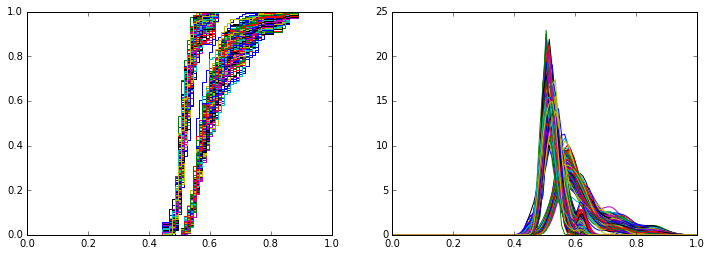

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.step(x, epcdf_store_sig.T);
ax1.step(x, epcdf_store_non.T);

ax2.plot(x, eppdf_store_sig.T);
ax2.plot(x, eppdf_store_non.T);

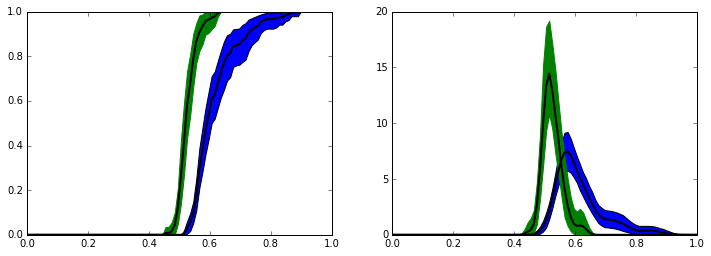

In [10]:
epcdf_store_non[0,:]
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,4))

# significant 
upci = np.percentile(epcdf_store_sig,97.5,axis=0)
loci = np.percentile(epcdf_store_sig,2.5,axis=0)
ax1.plot(x,np.mean(epcdf_store_sig,axis=0),linewidth=2,color='black')
ax1.fill_between(x,upci,loci)

# non significant 
upci = np.percentile(epcdf_store_non,97.5,axis=0)
loci = np.percentile(epcdf_store_non,2.5,axis=0)
ax1.plot(x,np.mean(epcdf_store_non,axis=0),linewidth=2,color='black')
ax1.fill_between(x,upci,loci,color='green')

##### PDF 

# significant 
upci = np.percentile(eppdf_store_sig,97.5,axis=0)
loci = np.percentile(eppdf_store_sig,2.5,axis=0)
ax2.plot(x,np.mean(eppdf_store_sig,axis=0),linewidth=2,color='black')
ax2.fill_between(x,upci,loci)

# non significant 
upci = np.percentile(eppdf_store_non,97.5,axis=0)
loci = np.percentile(eppdf_store_non,2.5,axis=0)
ax2.plot(x,np.mean(eppdf_store_non,axis=0),linewidth=2,color='black')
ax2.fill_between(x,upci,loci,color='green')

# Comparing Boot-Strap Distributions 

In [11]:
boot_results_sig = np.load('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_sig.npz')
eppdf_store_sig1 = boot_results_sig['eppdf_store']
#eppdf_store_nonsig1 = boot_results['eppdf_store_non']

boot_results_non = np.load('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_nonsig.npz')
eppdf_store_nonsig1 = boot_results_non['eppdf_store']


In [12]:
boot_results2 = np.load('../data_meta_analysis/data_derived_meta_analysis/bootstrap_results_average_within_ROI.npz')
eppdf_store_sig2 = boot_results2['eppdf_store_sig']
eppdf_store_nonsig2 = boot_results2['eppdf_store_non']



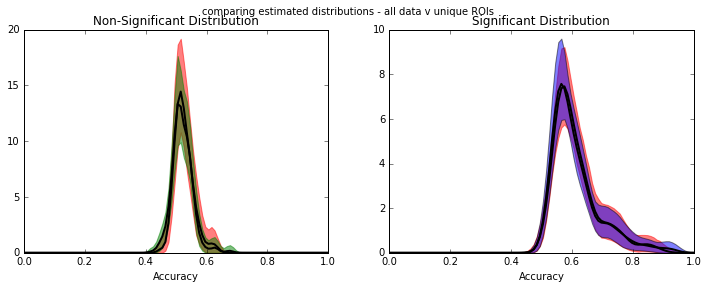

In [13]:
%matplotlib qt
%matplotlib inline
epcdf_store_non[0,:]
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,4))


# significant new 
upci = np.percentile(eppdf_store_nonsig2,97.5,axis=0)
loci = np.percentile(eppdf_store_nonsig2,2.5,axis=0)
ax1.plot(x,np.mean(eppdf_store_nonsig2,axis=0),linewidth=2,color='black')
ax1.fill_between(x,upci,loci,alpha=.5,color='red')

# significant original 
upci = np.percentile(eppdf_store_nonsig1,97.5,axis=0)
loci = np.percentile(eppdf_store_nonsig1,2.5,axis=0)
ax1.plot(x,np.mean(eppdf_store_nonsig1,axis=0),linewidth=2,color='black')
ax1.fill_between(x,upci,loci,alpha=0.5,color='green')


# significant new 
upci = np.percentile(eppdf_store_sig2,97.5,axis=0)
loci = np.percentile(eppdf_store_sig2,2.5,axis=0)
ax2.plot(x,np.mean(eppdf_store_sig2,axis=0),linewidth=2,color='black')
ax2.fill_between(x,upci,loci,alpha=.5,color='red')

# significant original 
upci = np.percentile(eppdf_store_sig1,97.5,axis=0)
loci = np.percentile(eppdf_store_sig1,2.5,axis=0)
ax2.plot(x,np.mean(eppdf_store_sig1,axis=0),linewidth=2,color='black')
ax2.fill_between(x,upci,loci,alpha=0.5,label='oringal')


ax1.set_title('Non-Significant Distribution')
ax2.set_title('Significant Distribution')

ax1.set_xlabel('Accuracy')
ax2.set_xlabel('Accuracy')
#plt.legend()
plt.suptitle('comparing estimated distributions - all data v unique ROIs')
#plt.tight_layout()
plt.savefig('../Figures/Supp/distributions_pdf_comparing_all_unique.png')